In [1]:
import os
import glob
import numpy as np
import pandas as pd
from obspy import UTCDateTime, read, Stream
import matplotlib.pyplot as plt

project_dir = f'{os.getcwd()}/..'
ppick_dir = f'{project_dir}/results/phasenet_diting_others/phasenet_files'
waveform_dir = f'{project_dir}/data/eq_data/2_waveforms'

ppick_file = f'{ppick_dir}/diting_phasenet_3d_grid.csv' 
pyrocko_markers = f'{project_dir}/results/phasenet_diting_others/00_47_all_picks_PN_PR_DT.txt'

allpick_file = f'{ppick_dir}/ALL_PICKS_POL.csv'

%load_ext autoreload
%autoreload 2

## Convert PyRocko picks into phasenet format csv file

## Read the `mseed` list and `polarity pick` files into dataframe 
##

In [2]:
# mseed_list = os.listdir(waveform_dir)
mseed_list = pd.read_csv(f'{ppick_dir}/../mseed_list_47.csv').fname.to_list()

# selected event
sel_ev = 'nc73783911.mseed'

# read the ppick file (includes phasenet, diting, pyrocko picks)
pol_df = pd.read_csv(allpick_file, parse_dates=['phase_time', 'pyrocko_phase_time'])
pol_df = pol_df[pol_df.phase_score > 0.8]

## Plot each station waveform into one subplot
using `plotWFpick_subplots` function in `WaveformPlotter` class

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


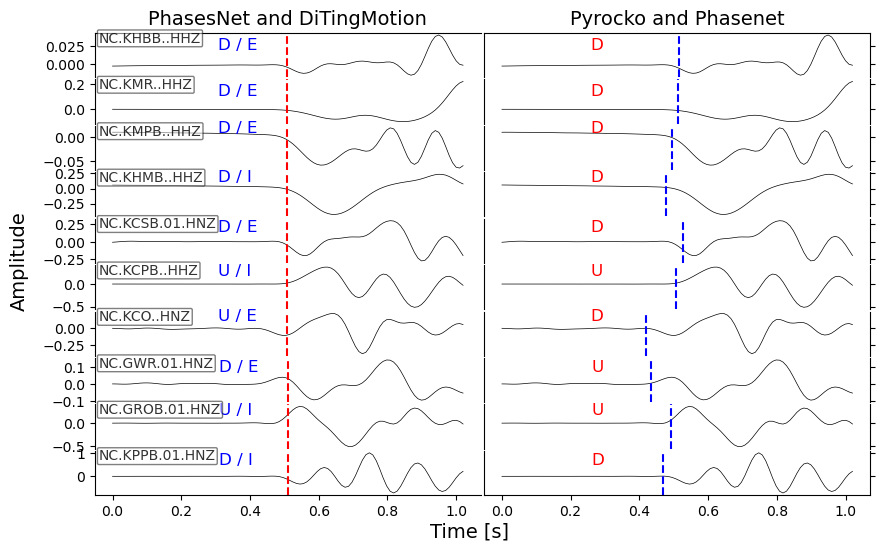

In [19]:
from classes_functions.my_class_funcs import WaveformPlotter
%load_ext autoreload
%autoreload 2

wfp = WaveformPlotter()
fig = wfp.plotWFpick_subplots(
    sel_ev, pol_df, waveform_dir, 
    figsize=(10, 6),
    n_subplots=10, 
    slice_len=0.5,
    hide_spines=True,
    hor_line=False,
    )

# Reduce the spacing between subplots
plt.subplots_adjust(hspace=0.05, wspace=0.01)

# plt.tight_layout()
plt.show()  

# One subplot for all stations

In [20]:
def WFprocessing(
    stn_id : str,
    pn_pick : UTCDateTime,
    st : Stream,
    sli : float = 0.5,
    normalize : bool = False,
):
    """ 
    Check for empty trace, detrend, taper, filter.
    Slice the trace around the PhasesNet pick.

    output: trace
    """ 
    ist = st.select(id=stn_id)
    tr = ist[0].copy()

    # check for empty trace
    if len(tr.data) > 0:
        tr.detrend('demean')
        try:
            tr.detrend('linear')
        except:
            tr.detrend('constant')
        
        try:
            tr.taper(0.001)
            tr.filter('bandpass', freqmin=.1, freqmax=10, corners=4, zerophase=True)  # Apply a bandpass filter
        except:
            pass
        
        if normalize:
            tr.data = tr.data/np.max(tr.data)
        # slice the trace
        tr = tr.slice(pn_pick - sli-0.01, pn_pick + sli) # around PhasesNet pick

        return tr

### Using class function:

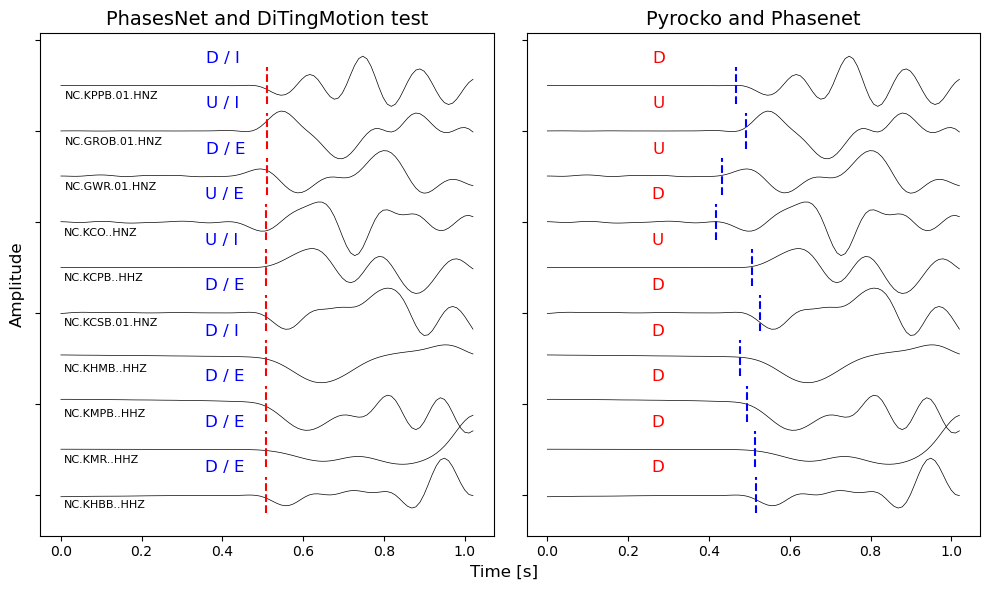

In [5]:
fig, [ax1, ax2] = wfp.plotWFpick_oneplot(
    mseed_file = sel_ev,
    pol_df = pol_df,
    waveform_dir = waveform_dir,
    n_subplots=10, 
    slice_len=0.5,
    zoom=2,
    normalize = True,
    hor_line = False,
)
ax1.set_title('PhasesNet and DiTingMotion test', fontsize=14)

# hide y axis labels
for ax in [ax1, ax2]: ax.set_yticklabels([])

plt.tight_layout()
plt.show()

# IDEA: ADD A COLUMN IN THE ALL PICKS FILE 'EVENT-STA-DIST', THIS WILL MAKE IT EASIER TO SORT WHEN PLOTTING